# **5. Bài toán phân cụm**

## **5.1. Mục tiêu**
* Lựa chọn đặc trưng tối ưu cho bài toán
* Xây dựng các cụm
* Mô tả đặc trưng các cụm
* Đánh giá và quan sát các cụm dựa trên hành vi của khách hàng

## **5.2. Import thư viện & Load dữ liệu**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('hotel_booking_clustering.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,total_guests,is_family_trip,adr_per_guest,lead_time_log,adr_log
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,0,2.0,0,0.0,5.837730,0.000000
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,0,2.0,0,0.0,6.603944,0.000000
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,1,1.0,0,75.0,2.079442,4.330733
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,1,1.0,0,75.0,2.639057,4.330733
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,2,2.0,0,49.0,2.708050,4.595120


In [4]:
df.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,total_guests,is_family_trip,adr_per_guest,lead_time_log,adr_log
119204,City Hotel,0,23,2017,August,35,30,2,5,2,...,Transient,96.14,0,0,7,2.0,0,48.070000,3.178054,4.576153
119205,City Hotel,0,102,2017,August,35,31,2,5,3,...,Transient,225.43,0,2,7,3.0,0,75.143333,4.634729,5.422436
119206,City Hotel,0,34,2017,August,35,31,2,5,2,...,Transient,157.71,0,4,7,2.0,0,78.855000,3.555348,5.067079
119207,City Hotel,0,109,2017,August,35,31,2,5,2,...,Transient,104.40,0,0,7,2.0,0,52.200000,4.700480,4.657763
119208,City Hotel,0,205,2017,August,35,29,2,7,2,...,Transient,151.20,0,2,9,2.0,0,75.600000,5.327876,5.025195


In [23]:
df.shape

(119209, 36)

In [24]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", num_cols) # Xác định cột số
print("Categorical:", cat_cols) # Xác định cột phân loại

Numeric: ['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_stay', 'total_guests', 'is_family_trip', 'adr_per_guest', 'lead_time_log', 'adr_log']
Categorical: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']


## **5.3. Thực hiện phân cụm**

In [33]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Chọn đặc trưng để phân cụm
# -----------------------------
cluster_features = [
    'lead_time',
    'total_stay',
    'adr_per_guest',
    'total_guests',
    'season',
    'market_segment',
    'customer_type',
    'total_of_special_requests',
]

cluster_features = [c for c in cluster_features if c in df.columns]
X_cluster = df[cluster_features].copy()

# --------------------
# 2. Khai báo kiểu cột
# --------------------
numeric_features = [c for c in cluster_features if pd.api.types.is_numeric_dtype(X_cluster[c])]
categorical_features = [c for c in cluster_features if c not in numeric_features]

# ---------------------------------------------------------
# 3. Preprocess: Scale num + OneHot cat
#    ÉP DENSE để dùng PCA: OneHotEncoder(sparse_output=False)
# ---------------------------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop"
)

# ---------------------------------------------------------
# 4. Tìm K tốt nhất bằng Silhouette (sampling)
#    - fit preprocess + PCA 1 lần
# ---------------------------------------------------------
def find_best_k(
    X,
    k_values=range(3, 8),
    random_state=42,
    pca_var=0.85,
    sample_size=8000,
    use_minibatch=True
):
    results = []
    best_k, best_score = None, -1

    # preprocess -> dense
    X_prep = preprocess.fit_transform(X)

    # PCA
    pca = PCA(
        n_components=pca_var,          # giữ % phương sai
        random_state=random_state,
        svd_solver="full"              # ổn định; có thể đổi "randomized" nếu rất lớn
    )
    X_pca = pca.fit_transform(X_prep)

    n = X_pca.shape[0]
    ss = min(sample_size, n)

    for k in k_values:
        if use_minibatch:
            model = MiniBatchKMeans(
                n_clusters=k,
                batch_size=4096,
                n_init=10,
                random_state=random_state
            )
        else:
            model = KMeans(
                n_clusters=k,
                n_init=20,
                max_iter=300,
                random_state=random_state,
                algorithm="lloyd"
            )

        labels = model.fit_predict(X_pca)

        score = silhouette_score(
            X_pca, labels,
            sample_size=ss,
            random_state=random_state
        )

        results.append({
            "k": k,
            "silhouette": score,
            "inertia": model.inertia_,
            "pca_components": X_pca.shape[1],
            "pca_var_kept": float(np.sum(pca.explained_variance_ratio_))
        })

        if score > best_score:
            best_k, best_score = k, score

    return pd.DataFrame(results).sort_values("k"), best_k, best_score

# -----------------
# 5. Tìm K tốt nhất
# -----------------
sil_table, best_k, best_sil = find_best_k(
    X_cluster,
    k_values=range(3, 8),
    random_state=42,
    pca_var=0.85,
    sample_size=8000,
    use_minibatch=True
)

print("Silhouette table:\n", sil_table)
print(f"\nBest K = {best_k} | Best silhouette = {best_sil:.4f}")

# ---------------------------------------------
# 6. Pipeline clustering cuối cùng (PCA thật)
# ---------------------------------------------
cluster_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.85, random_state=42, svd_solver="full")),
    ("kmeans", MiniBatchKMeans(n_clusters=best_k, batch_size=4096, n_init=10, random_state=42))
])

df["cluster"] = cluster_pipe.fit_predict(X_cluster)

# ------------------------------------------------
# 7. Profiling: mô tả cụm theo feature đã dùng
# ------------------------------------------------
print("\n=== Cluster Size ===")
print(df["cluster"].value_counts().sort_index())

print("\n=== Cluster profiling (numeric mean) ===")
if numeric_features:
    num_profile = df.groupby("cluster")[numeric_features].mean().round(3)
    print(num_profile)

print("\n=== Cluster profiling (categorical mode) ===")
for c in categorical_features:
    mode_by_cluster = df.groupby("cluster")[c].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
    print(f"\n{c} mode by cluster:")
    print(mode_by_cluster)

Silhouette table:
    k  silhouette        inertia  pca_components  pca_var_kept
0  3    0.193632  477468.635141               6        0.9049
1  4    0.199229  422246.333254               6        0.9049
2  5    0.217072  358578.148970               6        0.9049
3  6    0.223778  327211.690850               6        0.9049
4  7    0.185527  313230.527807               6        0.9049

Best K = 6 | Best silhouette = 0.2238

=== Cluster Size ===
cluster
0    12235
1    15319
2    17773
3    28267
4    11293
5    34322
Name: count, dtype: int64

=== Cluster profiling (numeric mean) ===
         lead_time  total_stay  adr_per_guest  total_guests  \
cluster                                                       
0          140.809       8.678         49.190         2.029   
1           60.042       2.585        105.782         1.168   
2          291.253       2.932         44.530         1.928   
3           64.447       2.930         53.318         1.985   
4           84.576       3.5

Bộ dữ liệu sau khi tiền xử lý bao gồm:
* Các biến số đã được chuẩn hóa
* Các biến phân loại được One-Hot Encoding, dẫn đến không gian đặc trưng có số chiều rất lớn
Trong không gian nhiều chiều:
Khoảng cách Euclidean trở nên kém ổn định
Silhouette Score có thể bị nhiễu bởi các chiều ít thông tin

**Do đó, PCA được sử dụng để giảm chiều dữ liệu, giữ lại các thành phần chính có phương sai lớn nhất.**

* PCA được cấu hình để giữ lại 85% tổng phương sai
* Silhouette Score được tính trên không gian PCA, thay vì không gian gốc

Cách làm này giúp

* Giảm nhiễu do chiều cao sau One-Hot Encoding
* Đảm bảo khoảng cách giữa các điểm phản ánh tốt hơn cấu trúc tiềm ẩn của dữ liệu
* Tăng tính ổn định và khả năng so sánh giữa các giá trị k

In [34]:
df.groupby("cluster")["is_canceled"].mean().round(3)

,is_canceled
cluster,
0,0.343
1,0.383
2,0.626
3,0.212
4,0.377
5,0.371


Tỷ lệ hủy phòng khác nhau giữa các cụm cho thấy:
* Các nhóm khách hàng  có mức độ rủi ro hủy phòng khác nhau
* Phân cụm đã khám phá được sự khác biệt hành vi có ý nghĩa thực tiễn

In [40]:
df['arrival_month_num'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month

def get_season(month):
    if month in [12,1,2]: return 'Winter'
    if month in [3,4,5]: return 'Spring'
    if month in [6,7,8]: return 'Summer'
    return 'Fall'

df['season'] = df['arrival_month_num'].apply(get_season) # Mùa du lịch


season_ratio = pd.crosstab(df["cluster"], df["season"], normalize="index")
print(season_ratio.round(3))

season    Fall  Spring  Summer  Winter
cluster                               
0        0.188   0.236   0.465   0.111
1        0.250   0.271   0.326   0.153
2        0.363   0.237   0.349   0.050
3        0.226   0.276   0.296   0.202
4        0.132   0.236   0.479   0.153
5        0.232   0.317   0.198   0.253


* **Cluster 0 – Summer Leisure Seekers ( Đây là nhóm khách phụ thuộc mạnh vào mùa du lịch cao điểm Phù hợp với kỳ nghỉ hè dài ngày (khớp với stay dài + lead time cao))**
  - 46.5% booking rơi vào mùa hè (cao)
  - Winter rất thấp (11.1%)

* Gợi ý hành động
  - Tối đa hóa giá & công suất mùa hè
  - Khuyến mãi sớm cho mùa hè năm sau
  - Giảm kỳ vọng doanh thu mùa đông


* **Cluster 1 – All-year Short Stay (Nhóm khách ít bị ảnh hưởng bởi mùa vụ, có thể là business / short trip )**
  - Phân bố khá đều
  - Summer vẫn cao nhất (32.6%) nhưng không quá lệch
* Gợi ý hành động
  - Pricing linh hoạt quanh năm
  - Ít cần seasonal promotion mạnh
* **Cluster 2 – Early Planners – Low Winter Demand** (
Nhóm này tránh mùa đông rõ rệt, Đặt rất sớm → thường là tour / group
)
  - Fall (36.3%) & Summer (34.9%) chiếm đa số
  - Winter gần như không có (5%)
* Gợi ý hành đông
  - Không nên kỳ vọng lấp đầy mùa đông từ cluster này
  - Dùng cho planning công suất dài hạn

* **Cluster 3 – Mainstream Seasonal Travelers (Nhóm khách đại trà- Phản ứng tốt với chiến dịch marketing theo mùa)**
  - Phân bố khá cân bằng
  - Summer (29.6%) & Spring (27.6%)
* Gợi ý hành động
  - Seasonal upsell
  - Campaign theo Spring–Summer
* **Cluster 4 – Family Summer Peak (
Gia đình / nhóm nhỏ -
Gắn chặt với kỳ nghỉ hè)**
  - Summer cao nhất toàn bộ clusters (47.9%)
  - Fall thấp nhất (13.2%)
* Gợi ý hành động
  - Family package mùa hè
  - Ưu tiên phòng lớn trong Summer
  - Off-season promotion mạnh nếu muốn kích cầu

* **Cluster 5 – Off-peak Flexible Travelers (Nhóm khách linh hoạt - Phù hợp lấp đầy mùa thấp điểm )**
  - Spring cao nhất (31.7%)
  - Winter cũng tương đối cao (25.3%)
  - Summer thấp nhất (19.8%)
* Gợi ý hành động
  - Dùng cluster này để chống mùa thấp điểm
  - Khuyến mãi Winter/Spring

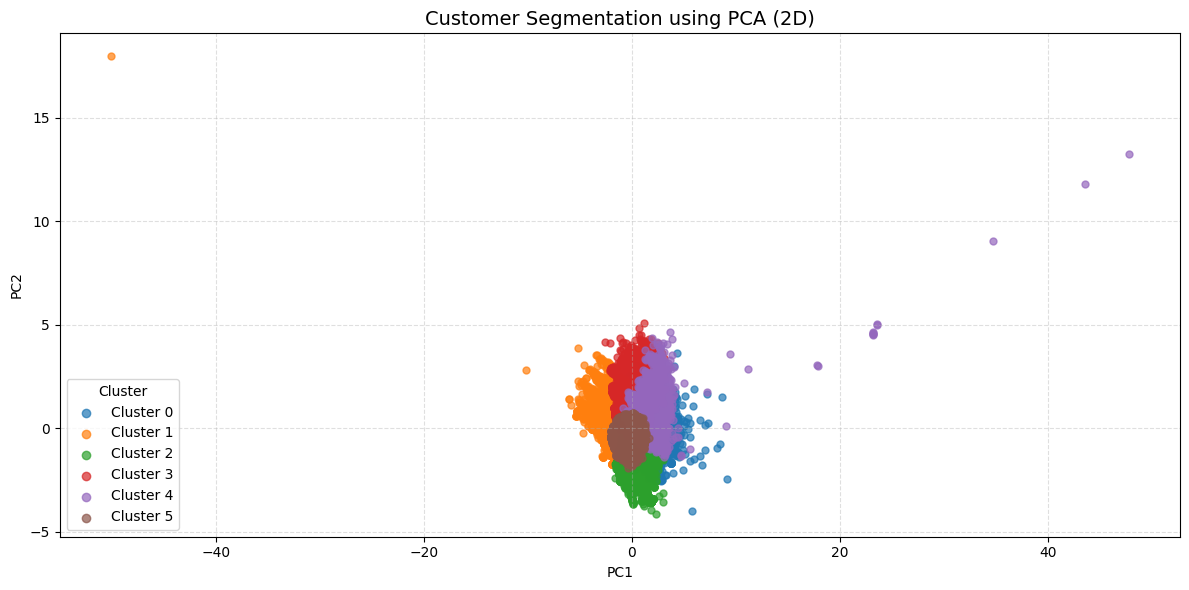

In [35]:
# Transform lại dữ liệu qua pipeline đã fit
X_prep = cluster_pipe.named_steps["preprocess"].transform(X_cluster)
X_pca  = cluster_pipe.named_steps["pca"].transform(X_prep)

# Gắn PCA vào dataframe
df_plot = df.copy()
df_plot["PC1"] = X_pca[:, 0]
df_plot["PC2"] = X_pca[:, 1]

# Lấy danh sách cluster
clusters = sorted(df_plot["cluster"].unique())

# Tạo figure
plt.figure(figsize=(12, 6))

# Vẽ từng cluster để có legend rõ ràng
for c in clusters:
    subset = df_plot[df_plot["cluster"] == c]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        s=25,
        alpha=0.7,
        label=f"Cluster {c}"
    )

# Trang trí biểu đồ
plt.title("Customer Segmentation using PCA (2D)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", markerscale=1.2)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

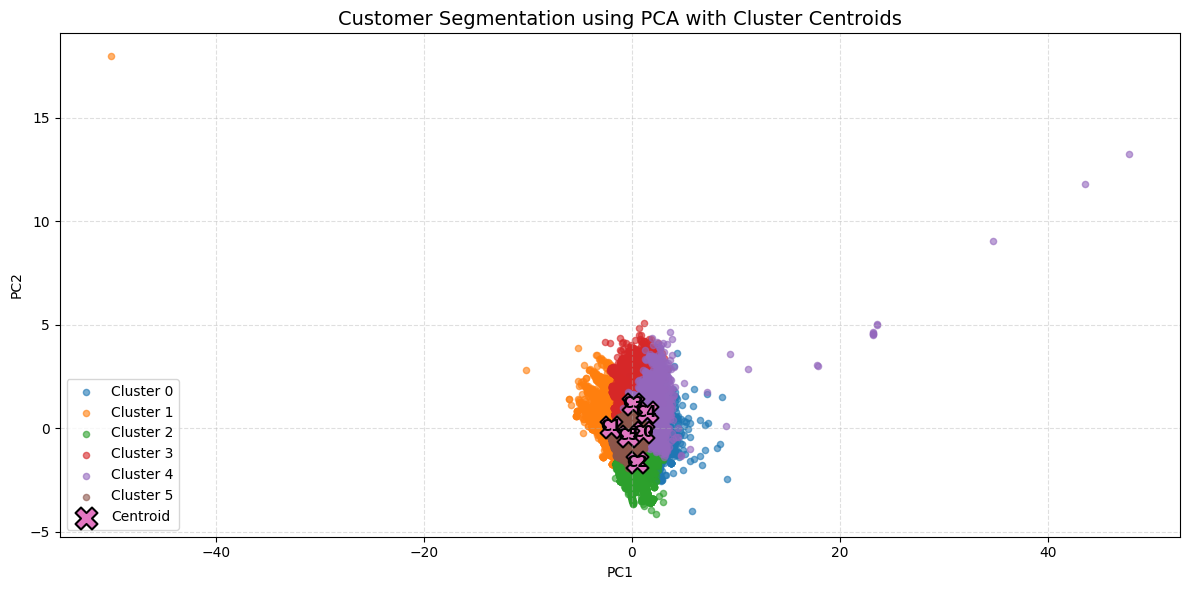

In [36]:
# Tính centroid trong không gian PCA
centroids_pca = (
    df_plot
    .groupby("cluster")[["PC1", "PC2"]]
    .mean()
)

clusters = sorted(df_plot["cluster"].unique())

plt.figure(figsize=(12, 6))

# Vẽ các điểm dữ liệu
for c in clusters:
    subset = df_plot[df_plot["cluster"] == c]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        s=20,
        alpha=0.6,
        label=f"Cluster {c}"
    )

# Vẽ tâm cụm (centroid)
plt.scatter(
    centroids_pca["PC1"],
    centroids_pca["PC2"],
    s=250,
    marker="X",
    edgecolor="black",
    linewidth=1.5,
    label="Centroid"
)

# Ghi nhãn cho tâm cụm
for c, row in centroids_pca.iterrows():
    plt.text(
        row["PC1"],
        row["PC2"],
        f"C{c}",
        fontsize=11,
        weight="bold",
        ha="center",
        va="center"
    )

# Trang trí
plt.title("Customer Segmentation using PCA with Cluster Centroids", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## **5.4. Kết luận**

1. Đánh giả băng Silhouetete Score cho thấy rằng với số k = 6 thì việc thực hiện phân cụm là ổn định nhất (Do hạn chế của thiết bị thực hiện huấn luyện mà tác giả đã sử dụng MiniKmeans thay thế tuy nhiên kết quả cũng không thay đổi)
  * Giá trị **0.2** không được xem là quá tốt tuy nhiên ta phải hiểu đây chính là dữ liệu thực tế và hoàn toàn chấp nhận được về hanh vi khách hàng (do con người luôn diễn ra và thay đổi liên tục dễ hiểu khi cụm ta phân loại cũng sẽ bị chồng lẫn)
  * Với giá trị như trên phân cụm chỉ hợp lý để phân tích hành vi và cũng không được xem là tiêu chí để phân loại
2. Kích thước các cụm có thể quan sát trên bảng
  * Không có cụm nảo nhỏ, phân bố tương đối cân bằng
3. Phân bố về các đặc trưng
Phân tích phân cụm cho thấy dữ liệu khách hàng có thể được chia thành 6 phân khúc hành vi rõ ràng, phản ánh sự khác biệt về